# Tutorial GRU4Rec

MAN 3160 - Sistemas Recomendadores



En este tutorial utilizaremos la [implementación oficial de Balázs Hidasi de Gru4Rec en Pytorch](https://github.com/hidasib/GRU4Rec_PyTorch_Official).

Entrenaremos el modelo en una versión reducida del [dataset YooChoose utilizado para el RecSys Challenge 2015](https://www.kaggle.com/datasets/chadgostopp/recsys-challenge-2015)

## Descargar datos y repositorio

In [7]:
# Librería para el manejo de archivos .7z

!pip install py7zr

  Obtaining dependency information for py7zr from https://files.pythonhosted.org/packages/2c/da/155bb1f692c067b9213c9c7b8c19a012a65027399606d623a25dfb1d3af1/py7zr-0.20.6-py3-none-any.whl.metadata
  Obtaining dependency information for pycryptodomex>=3.6.6 from https://files.pythonhosted.org/packages/8a/db/12a08d50aa8586c2e32b2b4461b89c0de057d1c637a13ac8b785dfd55327/pycryptodomex-3.18.0-cp35-abi3-win_amd64.whl.metadata
  Obtaining dependency information for pyzstd>=0.14.4 from https://files.pythonhosted.org/packages/d6/c0/59e2125bf474b64dd1eb4c29e69919f1f3d2f8874ff855f6148fcd1f9bda/pyzstd-0.15.9-cp39-cp39-win_amd64.whl.metadata
     ---------------------------------------- 0.0/46.1 kB ? eta -:--:--
     ---------------------------------------- 46.1/46.1 kB ? eta 0:00:00
   ---------------------------------------- 0.0/66.7 kB ? eta -:--:--
   ---------------------------------------- 66.7/66.7 kB ? eta 0:00:00
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -------

In [36]:
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     ----------------- ---------------------- 0.5/1.2 MB 11.1 MB/s eta 0:00:01
     ---------------------------------- ----- 1.0/1.2 MB 13.0 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 10.9 MB/s eta 0:00:00


In [1]:
# Clonamos el repositorio oficial

!git clone https://github.com/hidasib/GRU4Rec_PyTorch_Official --single-branch src

Cloning into 'src'...


In [2]:
# Descarga del dataset. Esto puede tomar hasta ~40 minutos, pero solo se debe realizar una vez

!curl https://s3-eu-west-1.amazonaws.com/yc-rdata/yoochoose-data.7z --output data.7z

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  273M    0 71510    0     0  47782      0  1:40:10  0:00:01  1:40:09 47800
  0  273M    0  154k    0     0  66375      0  1:12:07  0:00:02  1:12:05 66394
  0  273M    0  256k    0     0  78070      0  1:01:18  0:00:03  1:01:15 78087
  0  273M    0  375k    0     0  87490      0  0:54:42  0:00:04  0:54:38 87506
  0  273M    0  511k    0     0  96246      0  0:49:44  0:00:05  0:49:39  102k
  0  273M    0  630k    0     0    98k      0  0:47:30  0:00:06  0:47:24  114k
  0  273M    0  749k    0     0   100k      0  0:46:24  0:00:07  0:46:17  117k
  0  273M    0  902k    0     0   107k      0  0:43:34  0:00:08  0:43:26  127k
  0  273M    0 1021k    0     0   109k      0  0:42

In [1]:
from py7zr import unpack_7zarchive
import shutil

shutil.register_unpack_format('7zip', ['.7z'], unpack_7zarchive)
shutil.unpack_archive('data.7z', './rsc15')

# Preprocesar dataset

Vamos a editar manualmente el dataset para reducirlo a un tamaño adecuado para el tutorial y generar los datasets de entrenamiento y testeo

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt

In [6]:
!mkdir data

In [2]:
src_path = './rsc15/'
dst_path   = './data/'

In [3]:
def process(src_path, dst_path):
    data = pd.read_csv(src_path + 'yoochoose-clicks.dat', sep=',', header=None, usecols=[0,1,2], dtype={0:np.int32, 1:str, 2:np.int64})
    data.columns = ['SessionId', 'TimeStr', 'ItemId']

    # Convertimos el Timestamp en un objeto datetime
    data['Time'] = data.TimeStr.apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ').timestamp())
    del(data['TimeStr'])

    # Tomamos las sesiones de largo > 1
    session_lengths = data.groupby('SessionId').size()  
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>1].index)]

    # Filtramos los items que aparecen menos de 5 veces.
    item_supports = data.groupby('ItemId').size()
    data = data[np.in1d(data.ItemId, item_supports[item_supports>=5].index)]

    # Volvemos a filtrar las sesiones de largo 1
    session_lengths = data.groupby('SessionId').size()
    data = data[np.in1d(data.SessionId, session_lengths[session_lengths>=2].index)]

    # Vamos a definir el set de testeo como todas las interacciones ocurridas el último día.
    tmax = data.Time.max()
    session_max_times = data.groupby('SessionId').Time.max()

    session_train = session_max_times[session_max_times < tmax-86400].index
    train = data[np.in1d(data.SessionId, session_train)]

    session_test = session_max_times[session_max_times >= tmax-86400].index
    test = data[np.in1d(data.SessionId, session_test)]
    test = test[np.in1d(test.ItemId, train.ItemId)]
    tslength = test.groupby('SessionId').size()
    test = test[np.in1d(test.SessionId, tslength[tslength>=2].index)]
    print('Test set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(test), test.SessionId.nunique(), test.ItemId.nunique()))
    test.to_csv(dst_path + 'test.tsv', sep='\t', index=False)

    # Validation: Vamos a usar el penúltimo día para el set de validación
    tmax = train.Time.max()
    session_max_times = train.groupby('SessionId').Time.max()
    session_train = session_max_times[session_max_times < tmax-86400].index
    session_valid = session_max_times[session_max_times >= tmax-86400].index

    train_tr = train[np.in1d(train.SessionId, session_train)]
    valid = train[np.in1d(train.SessionId, session_valid)]
    valid = valid[np.in1d(valid.ItemId, train_tr.ItemId)]
    tslength = valid.groupby('SessionId').size()
    valid = valid[np.in1d(valid.SessionId, tslength[tslength>=2].index)]
    print('Validation set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(valid), valid.SessionId.nunique(), valid.ItemId.nunique()))
    valid.to_csv(dst_path + 'validation.tsv', sep='\t', index=False)


    print('Train set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(train_tr), train_tr.SessionId.nunique(), train_tr.ItemId.nunique()))
    train_tr.to_csv(dst_path + 'train.tsv', sep='\t', index=False)


In [4]:
process(src_path, dst_path)  # Toma ~ 10 minutos

Test set
	Events: 71222
	Sessions: 15324
	Items: 6751
Validation set
	Events: 58233
	Sessions: 12372
	Items: 6359
Train set
	Events: 31579006
	Sessions: 7953885
	Items: 37483


In [5]:
def train_fraction(df, fraction, prefix="train", path="./data/"):
    
    length = len(df['ItemId'])
    first_session = df.iloc[length - length//fraction].SessionId # Se toma el Id de la sesión que está en la fracción deseada
    df = df.loc[df['SessionId'] >= first_session] # Se guardan únicamente las sesiones cuyo Id sea mayor al Id encontrado
    
    # Nota: Este procedimiento sólo funciona correctamente si el dataset está ordenado según SessionId
    
    itemids = df['ItemId'].unique()
    n_items = len(itemids)

    print('Fractioned data set\n\tEvents: {}\n\tSessions: {}\n\tItems: {}'.format(len(df), df.SessionId.nunique(), df.ItemId.nunique()))
    filename = path + '{}_{}.tsv'.format(prefix, fraction)
    df.to_csv(filename, sep='\t', index=False)
    print("Saved as {}".format(filename))

In [6]:
# Para el propósito de esta demo, utilizamos una fracción del dataset de entrenamiento.
fraction = 64
train = pd.read_csv(dst_path + 'train.tsv', sep='\t', dtype={'ItemId':np.int64})
train_fraction(train, fraction)
train_frac = pd.read_csv(dst_path + 'train_64.tsv', sep='\t', dtype={'ItemId':np.int64})

Fractioned data set
	Events: 71391
	Sessions: 17450
	Items: 8724
Saved as ./data/train_64.tsv


In [26]:
train['SessionId'].is_monotonic_increasing

False

# Entrenamiento

Utilizamos los hiperparámetros óptimos reportados en el [repositorio oficial](https://github.com/hidasib/GRU4Rec_PyTorch_Official) para el dataset RSC15.

-m 1 5 10 20 Indica que la evaluación se realizará en recall@k y MRR@k, k = 1,5,10,20.

In [14]:
!python src/run.py ./data/train_64.tsv -t ./data/test.tsv -m 1 5 10 20 -ps layers=100,batch_size=32,dropout_p_embed=0.1,dropout_p_hidden=0,learning_rate=0.1,momentum=0,n_sample=2048,sample_alpha=0.75,bpreg=0,logq=1,loss=cross-entropy,constrained_embedding=True,elu_param=0,n_epochs=50 -d cuda:0

Creating GRU4Rec model on device "cuda:0"
SET   layers                  TO   [100]           (type: <class 'list'>)
SET   batch_size              TO   32              (type: <class 'int'>)
SET   dropout_p_embed         TO   0.1             (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.0             (type: <class 'float'>)
SET   learning_rate           TO   0.1             (type: <class 'float'>)
SET   momentum                TO   0.0             (type: <class 'float'>)
SET   n_sample                TO   2048            (type: <class 'int'>)
SET   sample_alpha            TO   0.75            (type: <class 'float'>)
SET   bpreg                   TO   0.0             (type: <class 'float'>)
SET   logq                    TO   1.0             (type: <class 'float'>)
SET   loss                    TO   cross-entropy   (type: <class 'str'>)
SET   constrained_embedding   TO   True            (type: <class 'bool'>)
SET   elu_param               TO   0.0             (type: <class '

## Resultados

Luego de 200 épocas, deberías obtener un desempeño similar al siguiente:

	 - Recall@20: 0.53
	 - MRR@20   : 0.21


Para replicar resultados del paper, utiliza el set de entrenamiento completo

## Aprovechando información implícita: Dwell Time

Podemos utilizar el tiempo que cada item fue visitado por cada usuario para realizar mejores recomendaciones.

El supuesto es: a mayor tiempo de permanencia (dwell time) en un item, más interesado está el usuario en dicho item.

Se hará item boosting en el set de entrenamiento.

In [13]:
def preprocess_df(df):    
    
    item_key = 'ItemId'
    session_key = 'SessionId'
    time_key = 'Time'
    
    df.sort_values([session_key, time_key], inplace=True)
        
    return df

In [8]:
def compute_dwell_time(df):
    times_t = np.roll(df['Time'], -1)
    times_dt  = df['Time']
    diffs = np.subtract(times_t, times_dt) # Se calcula la diferencia entre el instante de la interacción actual y la siguiente.
    length = len(df['ItemId'])
    
    
    offset_sessions = np.zeros(df['SessionId'].nunique()+1, dtype=np.int32)
    offset_sessions[1:] = df.groupby('SessionId').size().cumsum() 
    offset_sessions = offset_sessions - 1
    offset_sessions = np.roll(offset_sessions, -1) #offset_sessions es un vector que contiene los índices en los que termina una sesión.
    
    np.put(diffs.values, offset_sessions, np.zeros((offset_sessions.shape)), mode='raise') #Se asigna 0 al dwell time del último ítem de cada sesión.

    return diffs

In [9]:
def get_distribution(dts):
    # Imprime el boxplot para los elementos distintos de 0
    filtered = np.array(list(filter(lambda x: int(x) != 0, dts)))
    pd_dts = pd.DataFrame(filtered)
    pd_dts.boxplot(vert=False, showfliers=False)
    plt.xlabel("Seconds")
    plt.yticks([])
    plt.title("Dwell time distribution for RSC15 dataset")
    plt.show()
    pd_dts.describe()

In [10]:
def join_dwell_reps(df, dt, threshold=2000):
    # Se calcula dt//threshold + 1 y se guarda en una columna adicional del dataset
    dt //= threshold
    dt += 1   
    df['DwellReps'] = pd.Series(dt.astype(np.int64), index=dt.index)

In [11]:
def augment(df):    
    # Cada fila se repite 'DwellReps' veces.
    col_names = list(df.columns.values)[:3]
    augmented = np.repeat(df.values, df['DwellReps'], axis=0) 
    augmented = pd.DataFrame(data=augmented[:,:3],
                             columns=col_names)
    dtype = {'SessionId': np.int64, 
             'ItemId': np.int64, 
             'Time': np.float32}
    
    for k, v in dtype.items():
        augmented[k] = augmented[k].astype(v)                  
    
    return augmented

In [14]:
new_df = preprocess_df(train)
dts = compute_dwell_time(new_df)

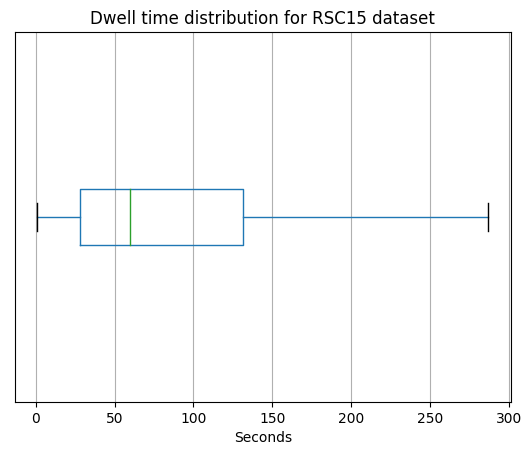

In [15]:
# Visualize
get_distribution(dts)

In [16]:
join_dwell_reps(new_df, dts, threshold=75)

df_aug = augment(new_df)
df_aug.to_csv("./data/augmented_train.csv", index=False, sep='\t')

In [17]:
# Nuevamente se toma una fracción del dataset
# (La fracción es menor por el proceso de inflación)
fraction = 64*7
train_fraction(df_aug, fraction, prefix='aug_train')

Fractioned data set
	Events: 151923
	Sessions: 16351
	Items: 8484
Saved as ./data/aug_train_448.tsv


## Entrenamiento con Dwell Time

In [19]:
!python src/run.py ./data/aug_train_448.tsv -t ./data/test.tsv -m 1 5 10 20 -ps layers=100,batch_size=32,dropout_p_embed=0.1,dropout_p_hidden=0,learning_rate=0.1,momentum=0,n_sample=2048,sample_alpha=0.75,bpreg=0,logq=1,loss=cross-entropy,constrained_embedding=True,elu_param=0,n_epochs=200 -d cuda:0

Creating GRU4Rec model on device "cuda:0"
SET   layers                  TO   [100]           (type: <class 'list'>)
SET   batch_size              TO   32              (type: <class 'int'>)
SET   dropout_p_embed         TO   0.1             (type: <class 'float'>)
SET   dropout_p_hidden        TO   0.0             (type: <class 'float'>)
SET   learning_rate           TO   0.1             (type: <class 'float'>)
SET   momentum                TO   0.0             (type: <class 'float'>)
SET   n_sample                TO   2048            (type: <class 'int'>)
SET   sample_alpha            TO   0.75            (type: <class 'float'>)
SET   bpreg                   TO   0.0             (type: <class 'float'>)
SET   logq                    TO   1.0             (type: <class 'float'>)
SET   loss                    TO   cross-entropy   (type: <class 'str'>)
SET   constrained_embedding   TO   True            (type: <class 'bool'>)
SET   elu_param               TO   0.0             (type: <class '